In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn plotly streamlit gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                            accuracy_score, f1_score, precision_score, recall_score,
                            silhouette_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
import datetime
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Create synthetic dataset
def generate_smart_home_data(num_homes=100, days=30):
    appliances = ['Refrigerator', 'AC', 'Washing Machine', 'TV', 'Oven', 'Lights']
    data = []

    for home_id in range(1, num_homes + 1):
        # Home characteristics
        home_type = random.choice(['Apartment', 'House', 'Condo'])
        num_occupants = random.randint(1, 5)
        home_size = random.randint(500, 3000)  # sq ft

        for day in range(1, days + 1):
            date = datetime.date(2023, 1, 1) + datetime.timedelta(days=day-1)
            weekday = date.weekday()  # 0=Monday, 6=Sunday
            is_weekend = weekday >= 5

            # Generate daily temperature (seasonal pattern)
            base_temp = 20 + 10 * np.sin(2 * np.pi * day / 365)
            temp = base_temp + random.uniform(-5, 5)

            # Base energy usage
            base_usage = home_size * 0.01 + num_occupants * 0.5

            for appliance in appliances:
                # Appliance characteristics
                age = random.randint(0, 10)  # years
                health_status = random.choices(['Healthy', 'Faulty'],
                                              weights=[0.95, 0.05])[0]

                # Appliance usage pattern
                if appliance == 'Refrigerator':
                    usage = random.uniform(1.5, 2.5)  # kWh per day
                    if health_status == 'Faulty':
                        usage *= random.uniform(1.3, 2.0)
                elif appliance == 'AC':
                    usage = max(0, (temp - 22) * random.uniform(0.5, 1.5))
                    if health_status == 'Faulty':
                        usage *= random.uniform(1.2, 1.8)
                elif appliance == 'Washing Machine':
                    usage = random.uniform(0.5, 1.5) if is_weekend else random.uniform(0.1, 0.5)
                elif appliance == 'TV':
                    usage = num_occupants * random.uniform(0.3, 0.7)
                elif appliance == 'Oven':
                    usage = random.uniform(0.2, 1.0) if is_weekend else random.uniform(0.1, 0.3)
                elif appliance == 'Lights':
                    usage = num_occupants * random.uniform(0.5, 1.0)

                # Add some noise
                usage += random.uniform(-0.2, 0.2)
                usage = max(0.1, usage)

                data.append([
                    home_id, home_type, num_occupants, home_size,
                    date, weekday, is_weekend, temp,
                    appliance, age, health_status, usage
                ])

    columns = [
        'home_id', 'home_type', 'num_occupants', 'home_size',
        'date', 'weekday', 'is_weekend', 'temperature',
        'appliance', 'appliance_age', 'health_status', 'daily_usage_kwh'
    ]
    return pd.DataFrame(data, columns=columns)

# Generate and save dataset
energy_data = generate_smart_home_data(num_homes=100, days=90)
energy_data.to_csv('smart_home_energy_data.csv', index=False)

# Download the dataset
from google.colab import files
files.download('smart_home_energy_data.csv')

# Display sample data
print("Sample of the generated dataset:")
display(energy_data.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sample of the generated dataset:


home_id home_type  num_occupants  home_size        date  weekday  \
0        1     Condo              1        602  2023-01-01        6   
1        1     Condo              1        602  2023-01-01        6   
2        1     Condo              1        602  2023-01-01        6   
3        1     Condo              1        602  2023-01-01        6   
4        1     Condo              1        602  2023-01-01        6   

   is_weekend  temperature        appliance  appliance_age health_status  \
0        True    22.587639     Refrigerator              3       Healthy   
1        True    22.587639               AC              8       Healthy   
2        True    22.587639  Washing Machine              3       Healthy   
3        True    22.587639               TV             10       Healthy   
4        True    22.587639             Oven              4       Healthy   

   daily_usage_kwh  
0         2.307151  
1         0.353676  
2         1.126517  
3         0.447492  
4         0.327527

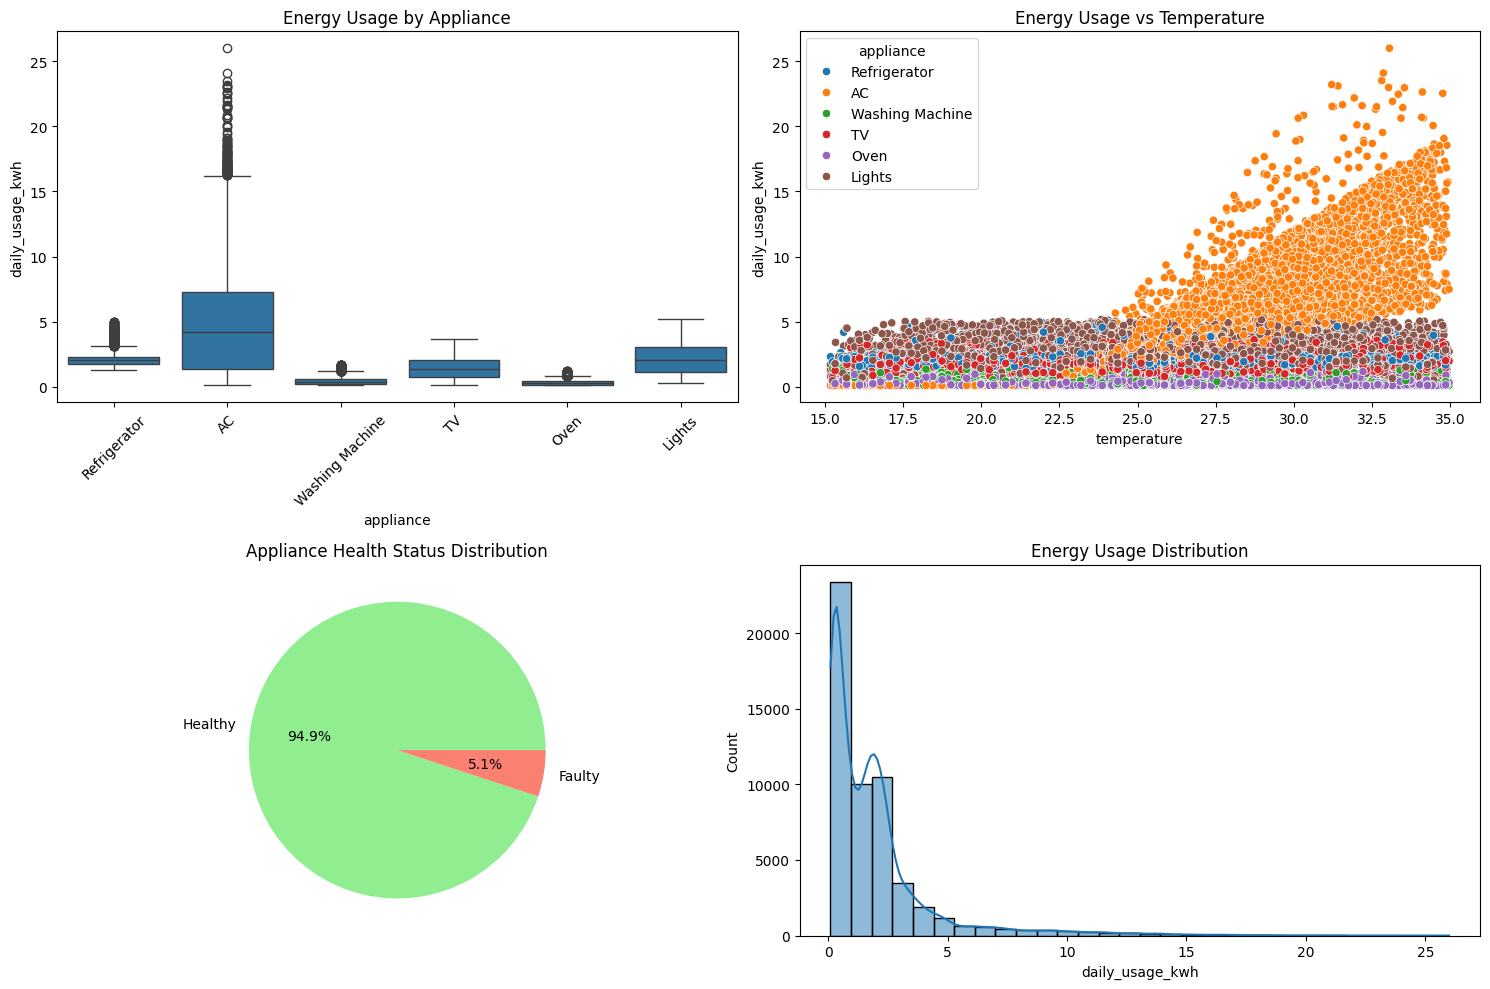

In [ ]:
# Load the dataset
energy_data = pd.read_csv('smart_home_energy_data.csv')
energy_data['date'] = pd.to_datetime(energy_data['date'])

# Feature engineering
def preprocess_data(df):
    # Create time-based features
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['season'] = (df['month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, etc.

    # Appliance usage statistics per home
    home_appliance_stats = df.groupby(['home_id', 'appliance'])['daily_usage_kwh'].agg(
        ['mean', 'std']).reset_index()
    home_appliance_stats.columns = ['home_id', 'appliance', 'appliance_mean_usage', 'appliance_std_usage']

    df = pd.merge(df, home_appliance_stats, on=['home_id', 'appliance'])

    # Calculate z-score for anomaly detection
    df['usage_zscore'] = (df['daily_usage_kwh'] - df['appliance_mean_usage']) / df['appliance_std_usage']

    # Label encoding for categorical variables
    le = LabelEncoder()
    df['home_type_encoded'] = le.fit_transform(df['home_type'])
    df['appliance_encoded'] = le.fit_transform(df['appliance'])
    df['health_status_encoded'] = le.fit_transform(df['health_status'])

    return df

energy_data = preprocess_data(energy_data)

# Visualize data distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='appliance', y='daily_usage_kwh', data=energy_data)
plt.title('Energy Usage by Appliance')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.scatterplot(x='temperature', y='daily_usage_kwh', hue='appliance', data=energy_data)
plt.title('Energy Usage vs Temperature')

plt.subplot(2, 2, 3)
health_counts = energy_data['health_status'].value_counts()
plt.pie(health_counts, labels=health_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Appliance Health Status Distribution')

plt.subplot(2, 2, 4)
sns.histplot(energy_data['daily_usage_kwh'], bins=30, kde=True)
plt.title('Energy Usage Distribution')

plt.tight_layout()
plt.show()

# Interactive plot of energy usage over time for a sample home
sample_home = energy_data[energy_data['home_id'] == 1]
fig = px.line(sample_home, x='date', y='daily_usage_kwh', color='appliance',
              title=f'Daily Energy Usage for Home 1 by Appliance')
fig.show()


Regression Model Performance:


MAE      RMSE        R2
Decision Tree  0.506782  0.937798  0.849905
Random Forest  0.444194  0.921343  0.855126

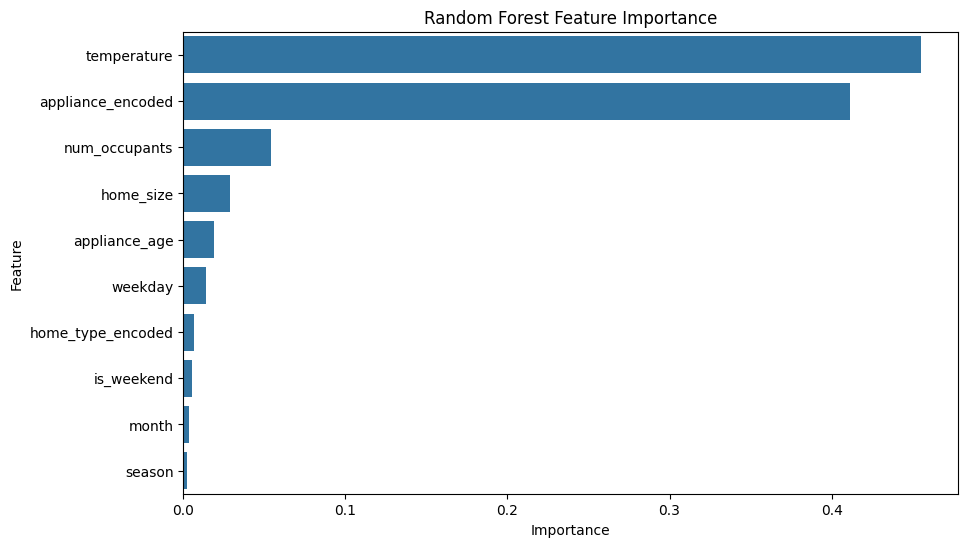

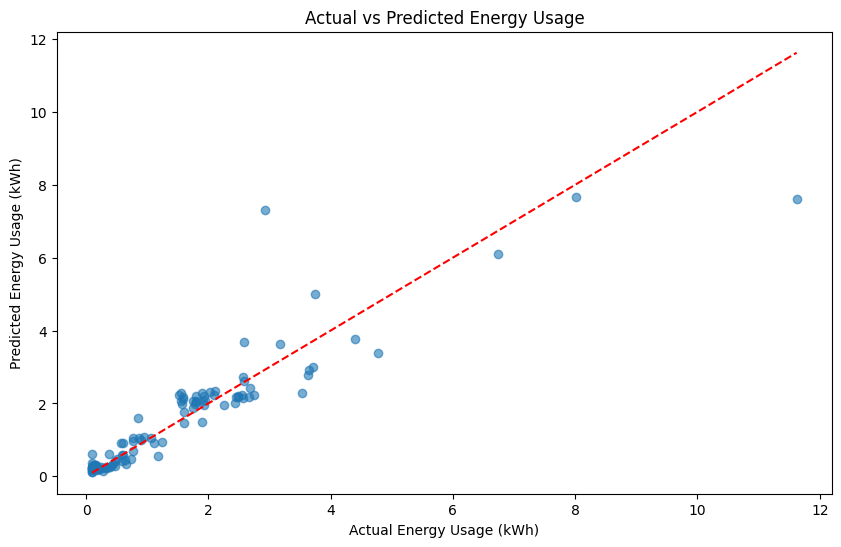

In [ ]:
# Prepare data for regression
regression_data = energy_data.copy()

# Features and target
X_reg = regression_data[[
    'home_type_encoded', 'num_occupants', 'home_size',
    'weekday', 'is_weekend', 'temperature', 'month',
    'appliance_encoded', 'appliance_age', 'season'
]]
y_reg = regression_data['daily_usage_kwh']

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)

    results[name] = {
        'MAE': mean_absolute_error(y_test_reg, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred)),
        'R2': r2_score(y_test_reg, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nRegression Model Performance:")
display(results_df)

# Feature importance for Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
features = X_reg.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

# Visualize predictions vs actual
sample_test = X_test_reg.sample(100, random_state=42)
y_true_sample = y_test_reg.loc[sample_test.index]
y_pred_sample = rf_model.predict(sample_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_true_sample, y_pred_sample, alpha=0.6)
plt.plot([min(y_true_sample), max(y_true_sample)],
         [min(y_true_sample), max(y_true_sample)],
         '--', color='red')
plt.xlabel('Actual Energy Usage (kWh)')
plt.ylabel('Predicted Energy Usage (kWh)')
plt.title('Actual vs Predicted Energy Usage')
plt.show()

# Interactive feature exploration
fig = px.scatter(regression_data.sample(1000, random_state=42),
                 x='temperature', y='daily_usage_kwh',
                 color='appliance', size='num_occupants',
                 hover_data=['home_type', 'appliance_age'],
                 title='Energy Usage by Temperature and Appliance')
fig.show()


Classification Model Performance:


Accuracy  Precision    Recall  F1 Score
Decision Tree  0.958889   0.958951  0.999903  0.978999
Random Forest  0.959630   0.960089  0.999420  0.979360

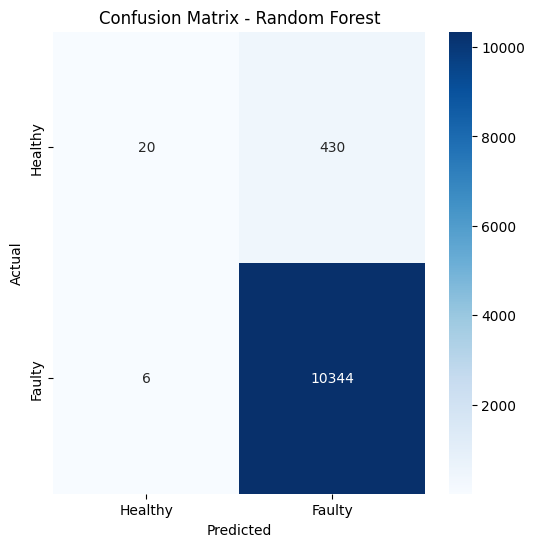

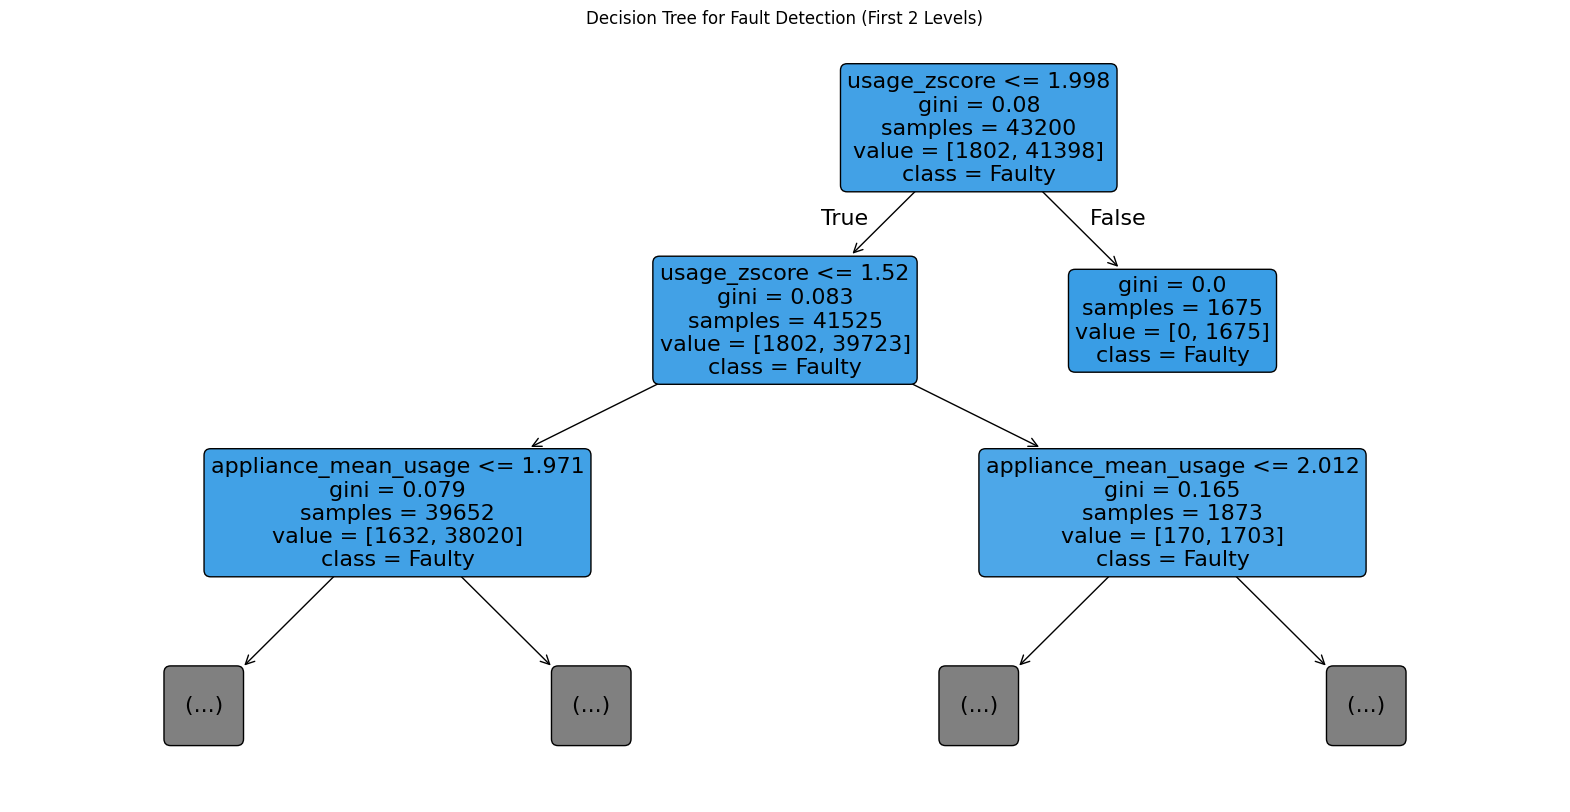

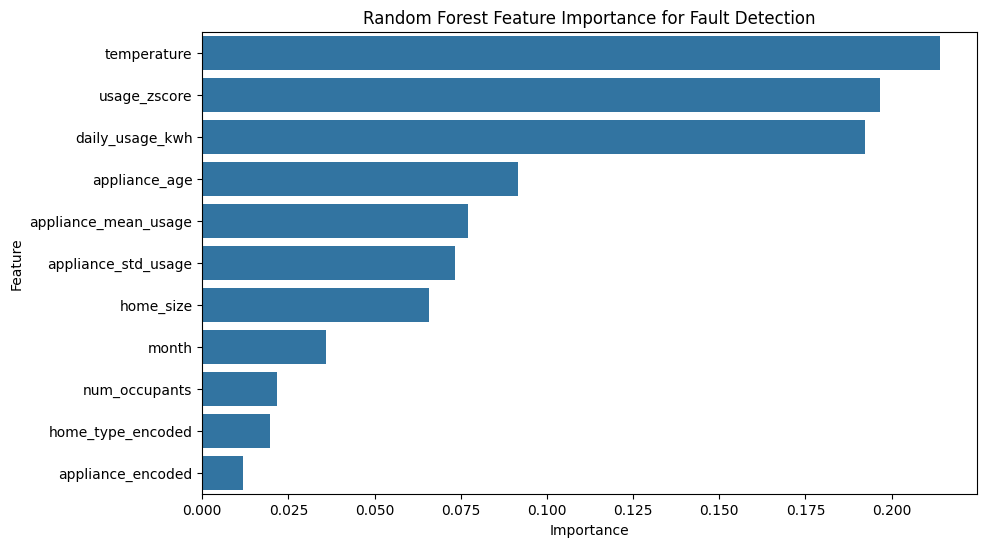

In [ ]:
# Prepare data for classification
classification_data = energy_data.copy()

# We'll use z-score > 2 as an additional faulty indicator
classification_data['usage_anomaly'] = (classification_data['usage_zscore'] > 2).astype(int)
classification_data['faulty'] = classification_data[['health_status_encoded', 'usage_anomaly']].max(axis=1)

# Features and target
X_clf = classification_data[[
    'home_type_encoded', 'num_occupants', 'home_size',
    'appliance_encoded', 'appliance_age', 'daily_usage_kwh',
    'appliance_mean_usage', 'appliance_std_usage', 'usage_zscore',
    'temperature', 'month'
]]
y_clf = classification_data['faulty']

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

# Initialize models
clf_models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
clf_results = {}
for name, model in clf_models.items():
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)

    clf_results[name] = {
        'Accuracy': accuracy_score(y_test_clf, y_pred),
        'Precision': precision_score(y_test_clf, y_pred),
        'Recall': recall_score(y_test_clf, y_pred),
        'F1 Score': f1_score(y_test_clf, y_pred)
    }

# Convert results to DataFrame
clf_results_df = pd.DataFrame(clf_results).T
print("\nClassification Model Performance:")
display(clf_results_df)

# Plot confusion matrix for Random Forest
from sklearn.metrics import confusion_matrix

rf_clf = clf_models['Random Forest']
y_pred_rf = rf_clf.predict(X_test_clf)
cm = confusion_matrix(y_test_clf, y_pred_rf)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Faulty'],
            yticklabels=['Healthy', 'Faulty'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf_models['Decision Tree'],
          feature_names=X_clf.columns,
          class_names=['Healthy', 'Faulty'],
          filled=True, rounded=True,
          max_depth=2)
plt.title('Decision Tree for Fault Detection (First 2 Levels)')
plt.show()

# Feature importance for classification
clf_importances = rf_clf.feature_importances_
clf_feature_importance = pd.DataFrame({'Feature': X_clf.columns, 'Importance': clf_importances})
clf_feature_importance = clf_feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=clf_feature_importance)
plt.title('Random Forest Feature Importance for Fault Detection')
plt.show()

# Interactive plot of faulty appliances
faulty_data = classification_data[classification_data['faulty'] == 1]
fig = px.scatter(faulty_data, x='appliance', y='daily_usage_kwh',
                 color='home_type', size='appliance_age',
                 hover_data=['home_id', 'date'],
                 title='Characteristics of Faulty Appliances')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

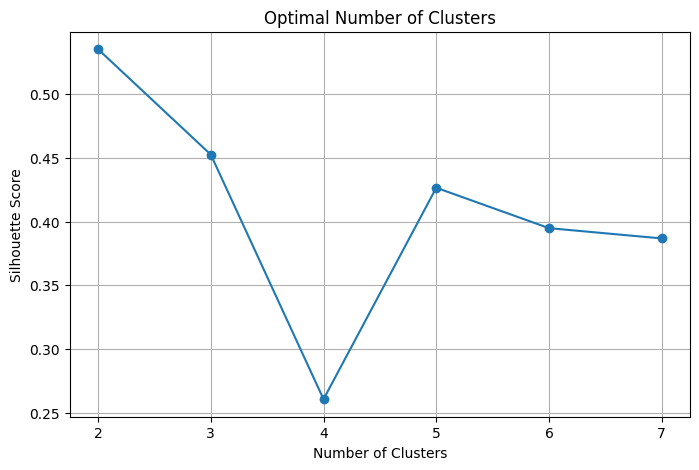


Cluster Summary:


daily_usage_kwh_mean  daily_usage_kwh_std  Refrigerator        AC  \
cluster                                                                      
0                    2.148633             2.346477      0.161788  0.380242   
1                    1.622927             2.372270      0.214645  0.510214   

         Washing Machine        TV      Oven    Lights  count  
cluster                                                        
0               0.038855  0.157980  0.025209  0.235925     55  
1               0.051308  0.076042  0.033429  0.114362     45

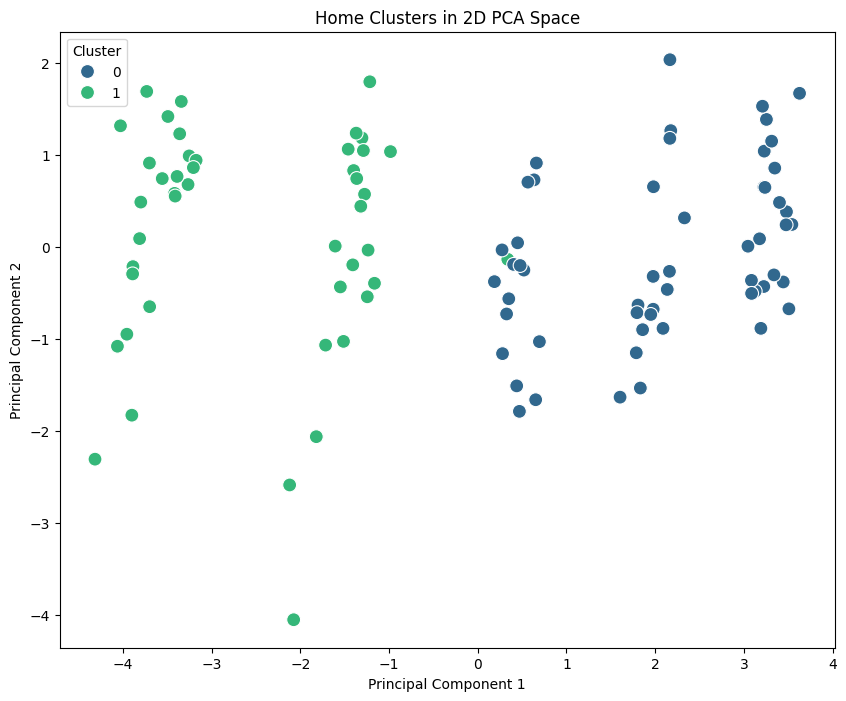

In [ ]:
# Prepare data for clustering
# Aggregate home-level features
home_features = energy_data.groupby('home_id').agg({
    'home_type': 'first',
    'num_occupants': 'first',
    'home_size': 'first',
    'daily_usage_kwh': ['mean', 'std', 'max'],
    'temperature': 'mean',
    'health_status_encoded': 'mean'
}).reset_index()

# Flatten multi-index columns
home_features.columns = ['_'.join(col).strip() if col[1] else col[0]
                        for col in home_features.columns.values]

# Appliance usage proportions
appliance_usage = energy_data.pivot_table(
    index='home_id', columns='appliance',
    values='daily_usage_kwh', aggfunc='mean').fillna(0)
appliance_usage = appliance_usage.div(appliance_usage.sum(axis=1), axis=0)

# Combine features
clustering_data = pd.merge(home_features, appliance_usage, on='home_id')

# Select features for clustering
X_cluster = clustering_data[[
    'daily_usage_kwh_mean', 'daily_usage_kwh_std',
    'Refrigerator', 'AC', 'Washing Machine', 'TV', 'Oven', 'Lights'
]]

# Standardize features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
for n_clusters in range(2, 8):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(X_cluster_scaled)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, cluster_labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 8), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid()
plt.show()

# Fit GMM with optimal clusters
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
cluster_labels = gmm.fit_predict(X_cluster_scaled)

# Add clusters to data
clustering_data['cluster'] = cluster_labels

# Analyze clusters
cluster_summary = clustering_data.groupby('cluster').agg({
    'daily_usage_kwh_mean': 'mean',
    'daily_usage_kwh_std': 'mean',
    'Refrigerator': 'mean',
    'AC': 'mean',
    'Washing Machine': 'mean',
    'TV': 'mean',
    'Oven': 'mean',
    'Lights': 'mean',
    'home_id': 'count'
}).rename(columns={'home_id': 'count'})

print("\nCluster Summary:")
display(cluster_summary)

# Visualize clusters
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)
clustering_data['pca1'] = X_pca[:, 0]
clustering_data['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster',
                data=clustering_data, palette='viridis', s=100)
plt.title('Home Clusters in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Interactive parallel coordinates plot
cluster_melt = clustering_data.melt(
    id_vars=['cluster', 'home_id'],
    value_vars=['daily_usage_kwh_mean', 'daily_usage_kwh_std',
                'Refrigerator', 'AC', 'Washing Machine', 'TV', 'Oven', 'Lights'],
    var_name='feature', value_name='value')

fig = px.line(cluster_melt, x='feature', y='value', color='cluster',
              facet_col='cluster', facet_col_wrap=2,
              title='Cluster Characteristics by Feature')
fig.show()

# Assign cluster labels to original data
# Solution 1: Drop the existing cluster column first if it exists
if 'cluster' in energy_data.columns:
    energy_data = energy_data.drop(columns=['cluster'])

# Then merge
energy_data = energy_data.merge(
    clustering_data[['home_id', 'cluster']],
    on='home_id'
)

# OR Solution 2: Use suffixes parameter
energy_data = energy_data.merge(
    clustering_data[['home_id', 'cluster']],
    on='home_id',
    suffixes=('', '_y')  # This will rename duplicate columns
)


In [ ]:
# First ensure the 'faulty' column exists in energy_data
if 'faulty' not in energy_data.columns:
    # Create faulty column based on health_status_encoded (1=Faulty, 0=Healthy)
    energy_data['faulty'] = energy_data['health_status_encoded']

# Now the recommendation function should work
def generate_recommendations(home_id):
    home_data = energy_data[energy_data['home_id'] == home_id].iloc[0]
    cluster = home_data['cluster']

    # Get cluster characteristics
    cluster_data = cluster_summary.loc[cluster]

    # Get home's appliances
    home_appliances = energy_data[energy_data['home_id'] == home_id]['appliance'].unique()

    recommendations = []

    # Cluster-based recommendations
    if cluster_data['daily_usage_kwh_mean'] > cluster_summary['daily_usage_kwh_mean'].quantile(0.75):
        recommendations.append("Your home is in the high energy usage cluster. Consider conducting an energy audit.")

    if 'AC' in home_appliances and cluster_data['AC'] > 0.3:
        recommendations.append("Your AC usage is high compared to other appliances. Consider using a programmable thermostat.")

    # Faulty appliance detection
    faulty_appliances = energy_data[(energy_data['home_id'] == home_id) &
                                  (energy_data['faulty'] == 1)]['appliance'].unique()
    if len(faulty_appliances) > 0:
        rec = f"Potential issues detected with: {', '.join(faulty_appliances)}. Consider maintenance or replacement."
        recommendations.append(rec)

    # Seasonal recommendations
    current_month = home_data['month']
    if current_month in [6, 7, 8]:  # Summer
        recommendations.append("Summer season tip: Use fans along with AC to reduce energy consumption.")
    elif current_month in [12, 1, 2]:  # Winter
        recommendations.append("Winter season tip: Lower your thermostat by a few degrees when away.")

    # If no specific recommendations, give general one
    if not recommendations:
        recommendations.append("Your energy usage patterns look efficient. Keep up the good work!")

    return recommendations

# Test again
sample_home_id = 42
print(f"\nRecommendations for Home {sample_home_id}:")
for i, rec in enumerate(generate_recommendations(sample_home_id), 1):
    print(f"{i}. {rec}")


Recommendations for Home 42:
1. Your AC usage is high compared to other appliances. Consider using a programmable thermostat.
2. Potential issues detected with: Refrigerator, AC, Washing Machine, TV, Oven, Lights. Consider maintenance or replacement.
3. Winter season tip: Lower your thermostat by a few degrees when away.


In [ ]:
# Create recommendation function
def generate_recommendations(home_id):
    home_data = energy_data[energy_data['home_id'] == home_id].iloc[0]
    cluster = home_data['cluster']

    # Get cluster characteristics
    cluster_data = cluster_summary.loc[cluster]

    # Get home's appliances
    home_appliances = energy_data[energy_data['home_id'] == home_id]['appliance'].unique()

    recommendations = []

    # Cluster-based recommendations
    if cluster_data['daily_usage_kwh_mean'] > cluster_summary['daily_usage_kwh_mean'].quantile(0.75):
        recommendations.append("Your home is in the high energy usage cluster. Consider conducting an energy audit.")

    if 'AC' in home_appliances and cluster_data['AC'] > 0.3:
        recommendations.append("Your AC usage is high compared to other appliances. Consider using a programmable thermostat.")

    # Faulty appliance detection
    faulty_appliances = energy_data[(energy_data['home_id'] == home_id) &
                                  (energy_data['faulty'] == 1)]['appliance'].unique()
    if len(faulty_appliances) > 0:
        rec = f"Potential issues detected with: {', '.join(faulty_appliances)}. Consider maintenance or replacement."
        recommendations.append(rec)

    # Seasonal recommendations
    current_month = home_data['month']
    if current_month in [6, 7, 8]:  # Summer
        recommendations.append("Summer season tip: Use fans along with AC to reduce energy consumption.")
    elif current_month in [12, 1, 2]:  # Winter
        recommendations.append("Winter season tip: Lower your thermostat by a few degrees when away.")

    # If no specific recommendations, give general one
    if not recommendations:
        recommendations.append("Your energy usage patterns look efficient. Keep up the good work!")

    return recommendations

# Test recommendation system
sample_home_id = 42
print(f"\nRecommendations for Home {sample_home_id}:")
for i, rec in enumerate(generate_recommendations(sample_home_id), 1):
    print(f"{i}. {rec}")

# Create a function to simulate real-time monitoring
def simulate_monitoring(home_id, days=7):
    home_data = energy_data[energy_data['home_id'] == home_id]
    recent_data = home_data.sort_values('date', ascending=False).head(days)

    print(f"\nMonitoring Report for Home {home_id} (Last {days} days):")
    print(f"Home Type: {home_data['home_type'].iloc[0]}")
    print(f"Occupants: {home_data['num_occupants'].iloc[0]}")
    print(f"Cluster: {home_data['cluster'].iloc[0]}")

    # Daily usage
    daily_usage = recent_data.groupby('date')['daily_usage_kwh'].sum()
    print("\nDaily Total Energy Usage:")
    display(daily_usage)

    # Appliance usage
    appliance_usage = recent_data.groupby('appliance')['daily_usage_kwh'].mean().sort_values(ascending=False)
    print("\nAverage Appliance Usage:")
    display(appliance_usage)

    # Faulty appliances
    faulty = recent_data[recent_data['faulty'] == 1]['appliance'].unique()
    if len(faulty) > 0:
        print(f"\n⚠️ Potential faulty appliances: {', '.join(faulty)}")
    else:
        print("\n✅ No potential appliance issues detected")

    # Predict next day's usage
    last_day_features = X_reg.loc[recent_data.index[-1]].values.reshape(1, -1)
    predicted_usage = models['Random Forest'].predict(last_day_features)[0]
    print(f"\nPredicted energy usage for next day: {predicted_usage:.2f} kWh")

    # Recommendations
    print("\nRecommendations:")
    for i, rec in enumerate(generate_recommendations(home_id), 1):
        print(f"{i}. {rec}")

# Test monitoring
simulate_monitoring(sample_home_id)

# Interactive recommendation explorer
def explore_recommendations(home_id):
    home_data = energy_data[energy_data['home_id'] == home_id]

    fig = px.bar(home_data, x='appliance', y='daily_usage_kwh',
                 color='health_status',
                 title=f'Appliance Usage for Home {home_id}')
    fig.show()

    cluster = home_data['cluster'].iloc[0]
    print(f"\nHome {home_id} is in Cluster {cluster}:")
    print(cluster_summary.loc[cluster])

    print("\nRecommendations:")
    for i, rec in enumerate(generate_recommendations(home_id), 1):
        print(f"{i}. {rec}")

# Interactive widget
from ipywidgets import interact, widgets

home_ids = energy_data['home_id'].unique()
interact(explore_recommendations,
         home_id=widgets.Dropdown(
             options=home_ids,
             value=sample_home_id,
             description='Home ID:',
             style={'description_width': 'initial'}
         ));


Recommendations for Home 42:
1. Your AC usage is high compared to other appliances. Consider using a programmable thermostat.
2. Potential issues detected with: Refrigerator, AC, Washing Machine, TV, Oven, Lights. Consider maintenance or replacement.
3. Winter season tip: Lower your thermostat by a few degrees when away.

Monitoring Report for Home 42 (Last 7 days):
Home Type: Apartment
Occupants: 1
Cluster: 1

Daily Total Energy Usage:


date
2023-03-30     0.820852
2023-03-31    12.154211
Name: daily_usage_kwh, dtype: float64


Average Appliance Usage:


appliance
AC                 8.116655
Refrigerator       2.252249
Lights             0.828768
TV                 0.598489
Oven               0.225515
Washing Machine    0.124618
Name: daily_usage_kwh, dtype: float64


⚠️ Potential faulty appliances: Lights, Oven, TV, Washing Machine, AC, Refrigerator

Predicted energy usage for next day: 0.82 kWh

Recommendations:
1. Your AC usage is high compared to other appliances. Consider using a programmable thermostat.
2. Potential issues detected with: Refrigerator, AC, Washing Machine, TV, Oven, Lights. Consider maintenance or replacement.
3. Winter season tip: Lower your thermostat by a few degrees when away.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



interactive(children=(Dropdown(description='Home ID:', index=41, options=(np.int64(1), np.int64(2), np.int64(3…

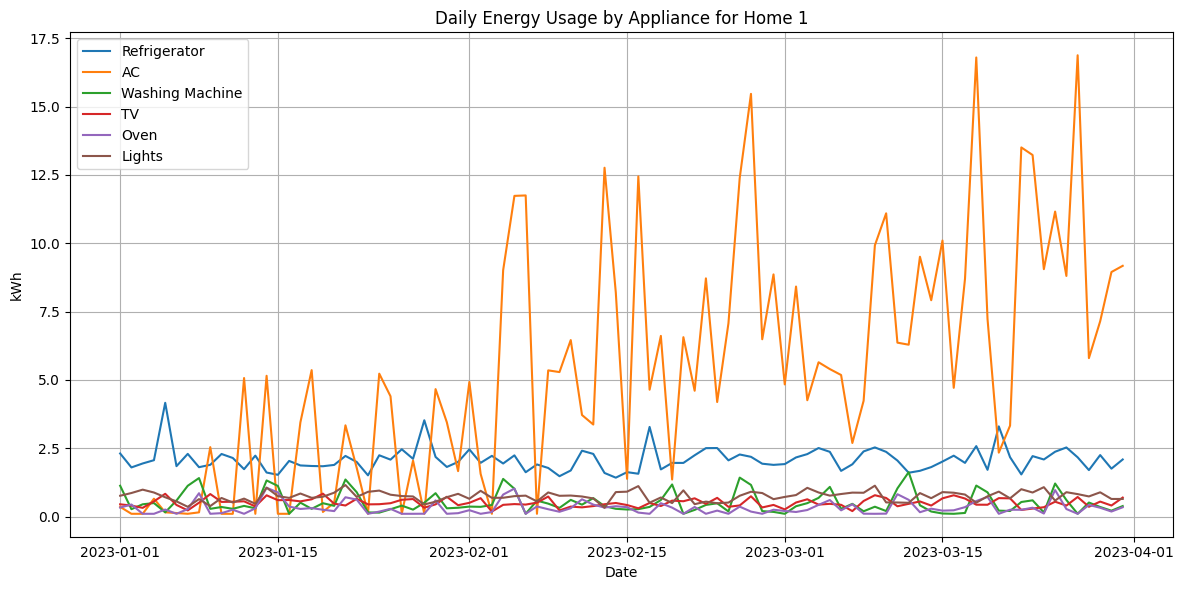

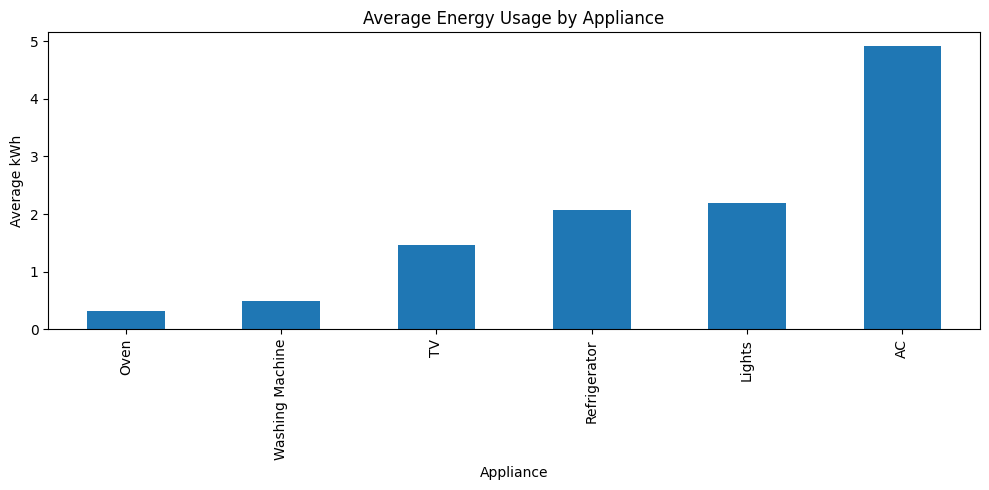

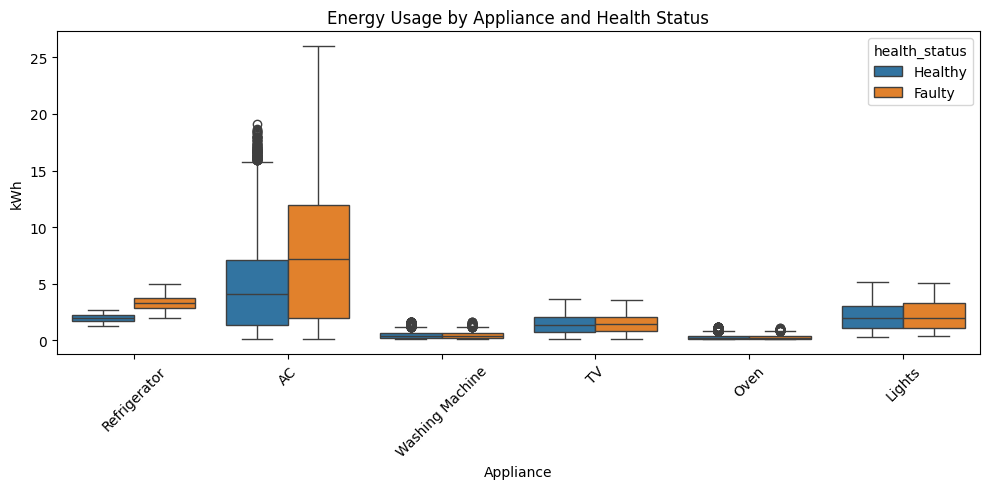

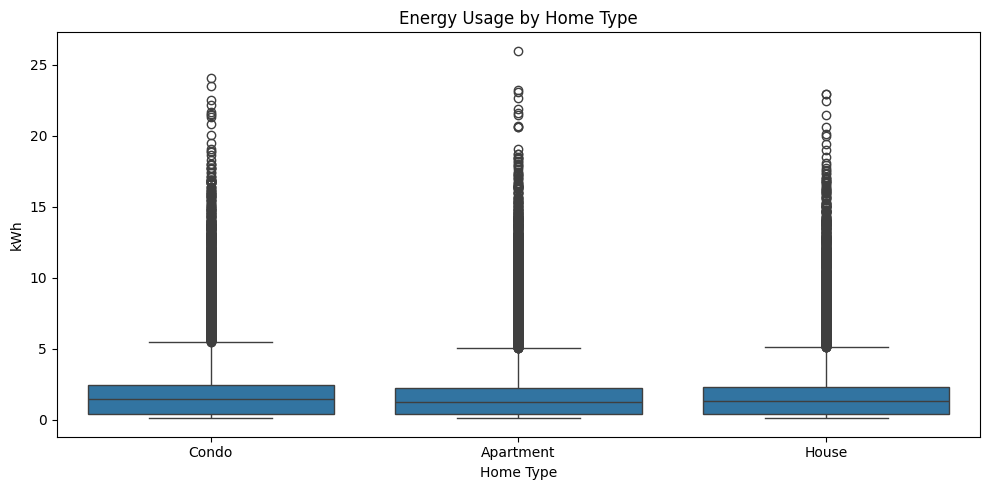

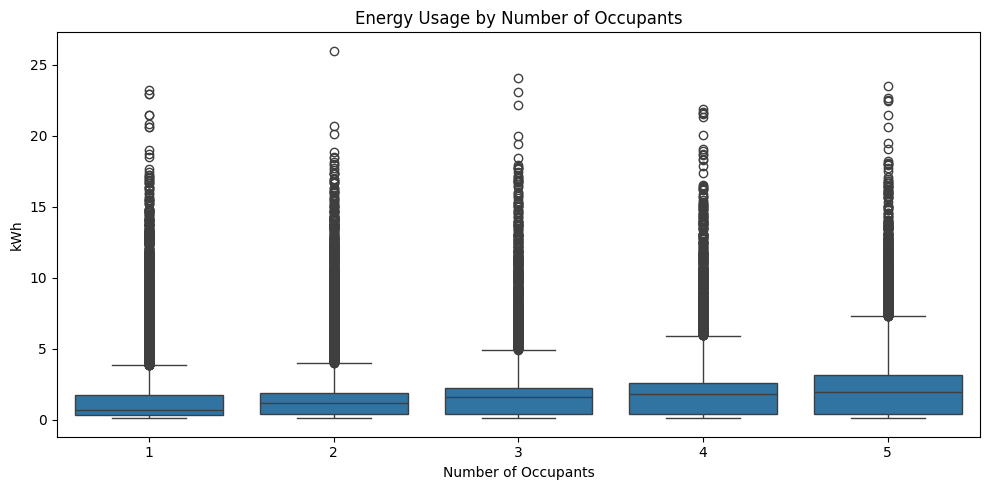

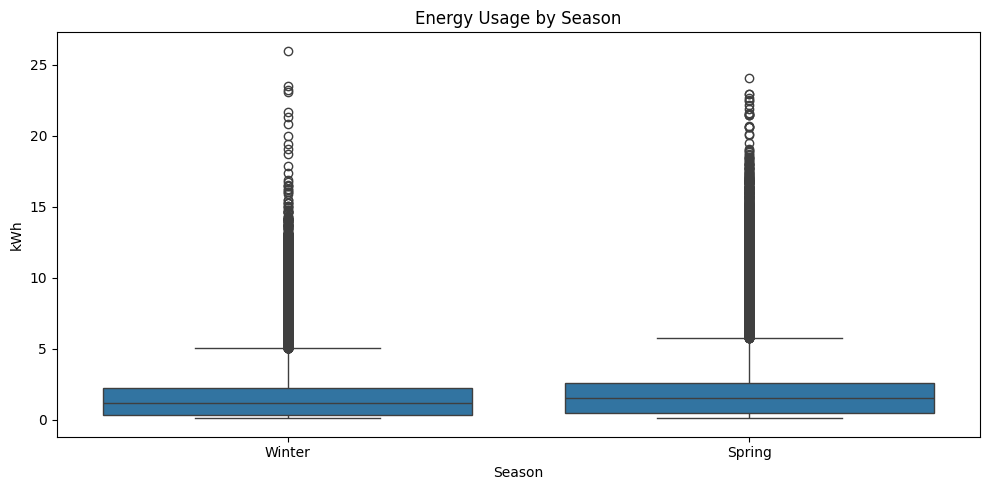

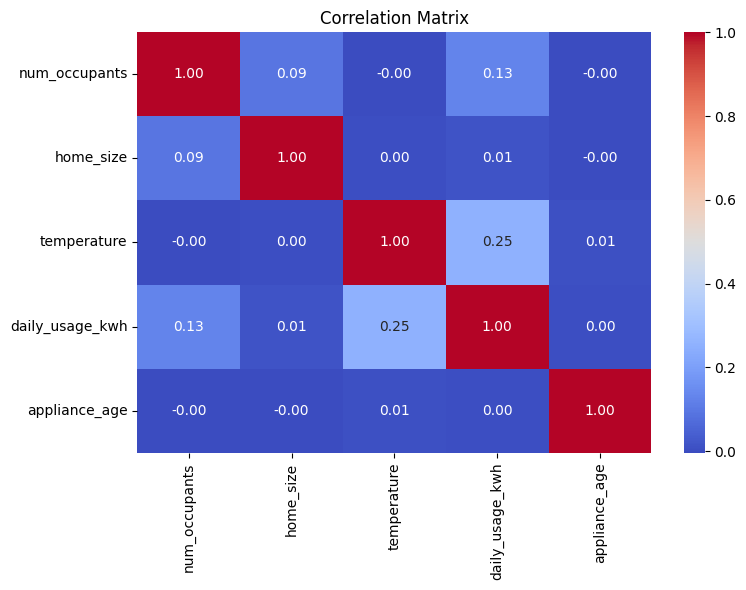

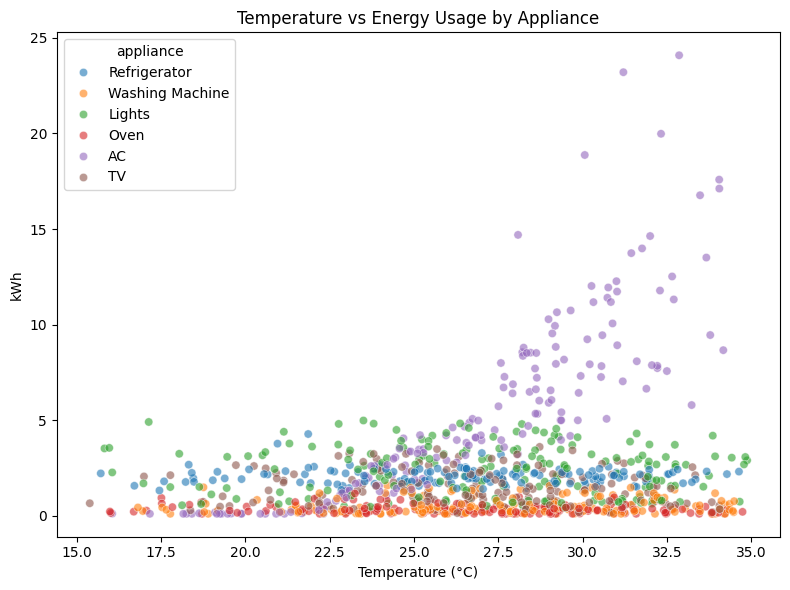

In [ ]:
# Re-run the EDA code for smart home energy data
%pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the smart home energy data
df = pd.read_csv('smart_home_energy_data.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Create additional time-based features
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['season'] = (df['month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, etc.

# Plot 1: Time Series - Daily Energy Usage by Appliance (sample home)
sample_home = df[df['home_id'] == 1]
plt.figure(figsize=(12, 6))
for appliance in sample_home['appliance'].unique():
    app_data = sample_home[sample_home['appliance'] == appliance]
    plt.plot(app_data['date'], app_data['daily_usage_kwh'], label=appliance)
plt.title("Daily Energy Usage by Appliance for Home 1")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Average Energy Usage by Appliance
plt.figure(figsize=(10, 5))
df.groupby('appliance')['daily_usage_kwh'].mean().sort_values().plot(kind='bar')
plt.title("Average Energy Usage by Appliance")
plt.ylabel("Average kWh")
plt.xlabel("Appliance")
plt.tight_layout()
plt.show()

# Plot 3: Energy Usage by Appliance Health Status
plt.figure(figsize=(10, 5))
sns.boxplot(x='appliance', y='daily_usage_kwh', hue='health_status', data=df)
plt.title("Energy Usage by Appliance and Health Status")
plt.ylabel("kWh")
plt.xlabel("Appliance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 4: Energy Usage by Home Type
plt.figure(figsize=(10, 5))
sns.boxplot(x='home_type', y='daily_usage_kwh', data=df)
plt.title("Energy Usage by Home Type")
plt.ylabel("kWh")
plt.xlabel("Home Type")
plt.tight_layout()
plt.show()

# Plot 5: Energy Usage by Number of Occupants
plt.figure(figsize=(10, 5))
sns.boxplot(x='num_occupants', y='daily_usage_kwh', data=df)
plt.title("Energy Usage by Number of Occupants")
plt.ylabel("kWh")
plt.xlabel("Number of Occupants")
plt.tight_layout()
plt.show()

# Plot 6: Energy Usage by Season
plt.figure(figsize=(10, 5))
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['season'].map(season_names)
sns.boxplot(x='season_name', y='daily_usage_kwh', data=df)
plt.title("Energy Usage by Season")
plt.ylabel("kWh")
plt.xlabel("Season")
plt.tight_layout()
plt.show()

# Plot 7: Correlation Heatmap (for numeric features)
numeric_cols = ['num_occupants', 'home_size', 'temperature', 'daily_usage_kwh', 'appliance_age']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Plot 8: Temperature vs Energy Usage
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature', y='daily_usage_kwh', hue='appliance',
               data=df.sample(1000, random_state=42), alpha=0.6)
plt.title("Temperature vs Energy Usage by Appliance")
plt.ylabel("kWh")
plt.xlabel("Temperature (°C)")
plt.tight_layout()
plt.show()